# Fit SARIMA models to housing prices
This notebook fits SARIMA models to the RedFin housing price data. The idea is to fit a different model to each region, using traditional time-series model selection criteria (AIC/BIC) to make the decision automatically.

As is, we expect the model to perform very poorly, since the long-term predictions of an ARIMA model will simply tend toward some (possibly seasonal) mean. For this reason, I also fit a rolling out-of-sample fit where use the model to make predictions one step ahead at a time.

## Setup

In [33]:
# Packages
import pandas as pd, pmdarima as pm, numpy as np
import time

pd.options.mode.chained_assignment = None  # default='warn'

In [48]:
# File location -- update as appropriate
DATA_DIR = 'C:\\Users\\Michael\\Documents\\JHU EP\\625.742 - Theory of Machine Learning\\Project\\'
OOS_DATE = '12/1/2019'

In [7]:
# Load the raw housing data
home_data = pd.read_csv(f"{DATA_DIR}combined_home_data.csv")
home_data.head()

C:\Users\Michael\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,169,245,284,288,292,304,308,312,348,352,356) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,region_id,period_begin,period_end,total_homes_sold,total_homes_sold_yoy,average_homes_sold,average_homes_sold_yoy,total_homes_sold_with_price_drops,total_homes_sold_with_price_drops_yoy,average_homes_sold_with_price_drops,...,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Median_Household_Income_2019,Med_HH_Income_Percent_of_State_Total_2019
0,525,2019-05-20,2019-06-16,141.0,0.060150,35.0,0.060606,41.0,0.640000,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
1,525,2019-05-27,2019-06-23,148.0,0.129771,37.0,0.156250,40.0,0.818182,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
2,525,2019-05-13,2019-06-09,152.0,0.169231,38.0,0.187500,43.0,0.433333,10.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
3,525,2019-05-06,2019-06-02,149.0,0.182540,37.0,0.193548,39.0,0.344828,9.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5
4,525,2020-01-20,2020-02-16,105.0,0.153846,26.0,0.181818,35.0,0.346154,8.0,...,"55,720","53,731","1,989",3.6,"54,475","51,009","3,466",6.4,"59,193",95.5


In [16]:
home_price_data = home_data[['state_code','county_name','region_id','period_begin','median_sale_price']].dropna()
home_price_data.head()

,state_code,county_name,region_id,period_begin,median_sale_price
0,GA,Carroll County,525,2019-05-20,180893.7
1,GA,Carroll County,525,2019-05-27,175800.0
2,GA,Carroll County,525,2019-05-13,177768.7
3,GA,Carroll County,525,2019-05-06,179818.7
4,GA,Carroll County,525,2020-01-20,161210.0


## Example: fitting to a particular county

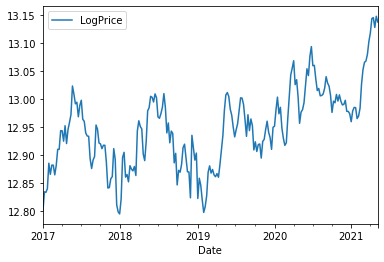

In [134]:
my_state = 'MD'
my_county = 'Howard County'
my_data = home_price_data.loc[(home_price_data['state_code']==my_state) & (home_price_data['county_name']==my_county),:]
my_data['Date'] = pd.to_datetime(my_data['period_begin'])
my_data['LogPrice'] = np.log(my_data['median_sale_price'])
my_data = my_data[['Date','LogPrice']].set_index('Date').sort_index()
my_data.plot()

In [152]:
# Fit a date-grid from IS to OOS and align
date_grid = pd.date_range(start=my_data.index[0],end=my_data.index[-1],freq='7D')
date_grid = pd.DataFrame(date_grid,columns={'Date'}).set_index('Date')
aligned_data, _ = my_data.align(date_grid, method='pad')
aligned_data.head()

,LogPrice
Date,
2017-01-02,12.800055
2017-01-09,12.834014
2017-01-16,12.833013
2017-01-23,12.839669
2017-01-30,12.885058


In [153]:
train_data = aligned_data .loc[aligned_data.index <= OOS_DATE,:]
my_model = pm.auto_arima(train_data, seasonal=True)
my_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  152
Model:               SARIMAX(2, 0, 4)   Log Likelihood                 369.437
Date:                Sat, 24 Jul 2021   AIC                           -722.875
Time:                        16:50:59   BIC                           -698.684
Sample:                             0   HQIC                          -713.048
                                - 152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0075      0.863      1.168      0.243      -0.684       2.699
ar.L1          0.7832      0.154      5.085      0.000       0.481       1.085
ar.L2          0.1387      0.116      1.200      0.230      -0.088       0.365
ma.L1          0.2682      0.146      1.840      0.066      -0.018       0.554
ma.L2          0.2410      0.115      2.089      0.037       0.015       0.467
ma.L3          0.1736      0.124      1.397      0.162      -0.070       0.417
ma.L4         -0.7126      0.128     -5.547      0.000      -0.964      -0.461
sigma2         0.0004   4.42e-05      9.649      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.70
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.21   Skew:                             0.16
Prob(H) (two-sided):                  0.50   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
fit_data = aligned_data.copy(deep=True)

# Fill in the in-sample fit
fit_data.loc[fit_data.index <= OOS_DATE, 'Prediction'] = my_model.predict_in_sample()

# Add a constant prediction throughout the OOS prediction
fit_data.loc[fit_data.index > OOS_DATE, 'Prediction'] = my_model.predict(sum([1 for v in fit_data.index > OOS_DATE if v]))

# Update the model in an online fashion
rolling_model = my_model
test_data = aligned_data[aligned_data.index > OOS_DATE]
for t in test_data.index:
    test_data.loc[t,'Rolling Prediction'] = rolling_model.predict(n_periods=1)
    rolling_model.update(test_data.loc[t,'LogPrice'])

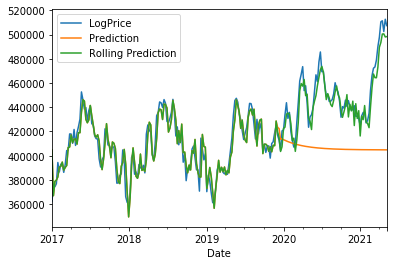

In [168]:
fit_data['Rolling Prediction'] = fit_data['Prediction']
fit_data.loc[fit_data.index>=test_data.index[0],'Rolling Prediction'] = test_data['Rolling Prediction']
np.exp(fit_data).plot()

## Fitting to all counties

In [564]:
def get_sarima_predictions(data, oos_date = OOS_DATE, fit_log=True):
    """ Main helper for fitting SARIMA model predictions. Similar to example above, fits
        a full-sample prediction and also does one-step-ahead predictions. Designed to be
        called on a given county / region id at a time. Returns a pandas data frame with the
        predicted values.
    """
    # Fix the date and sort
    ord_data = data.copy(deep=True)
    ord_data['Date'] = pd.to_datetime(ord_data['period_begin'])
    ord_data = ord_data.set_index('Date').sort_index()
    ord_data['Input'] = ord_data['median_sale_price']
    if fit_log:
        ord_data['Input'] = np.log(ord_data['Input'])

    # Create a uniform date grid
    date_grid = pd.date_range(start=ord_data.index[0],end=ord_data.index[-1],freq='7D')
    date_grid = pd.DataFrame(date_grid,columns={'Date'}).set_index('Date')
    aligned_data, _ = ord_data.align(date_grid, method='pad')
    aligned_data = aligned_data[['period_begin','Input']]

    # Fit the base model
    is_data = aligned_data.loc[aligned_data.index < oos_date,['Input']]
    auto_model = pm.auto_arima(is_data)
    auto_model.summary()

    # Calculate the long-term prediction
    n_is = sum([1 for v in aligned_data.index < oos_date if v])
    n_oos = sum([1 for v in aligned_data.index >= oos_date if v])
    aligned_data.loc[aligned_data.index[range(n_is)],'Prediction'] = auto_model.predict_in_sample()
    aligned_data.loc[aligned_data.index[range(n_is,n_is+n_oos)],'Prediction']  = auto_model.predict(n_oos)

    # Calculate the rolling predictions
    rolling_model = auto_model
    aligned_data['Rolling Prediction'] = aligned_data['Prediction']
    for t in range(n_is,n_is+n_oos):
        ti = aligned_data.index[t]
        aligned_data.loc[ti,'Rolling Prediction'] = rolling_model.predict(1)
        rolling_model.update(aligned_data.loc[ti,'Input'])

    # Replace zeros with NaNs to deal with integrated models starting at zero
    aligned_data['Prediction'] = aligned_data['Prediction'].replace({0:np.nan})
    aligned_data['Rolling Prediction'] = aligned_data['Rolling Prediction'].replace({0:np.nan})

    # Undo the log transformation
    if fit_log:
        aligned_data[['Input','Prediction','Rolling Prediction']] = np.exp(aligned_data[['Input','Prediction','Rolling Prediction']])

    # ... just to be safe, remove the first row (which is in-sample anyway) to deal with warmup issues
    return aligned_data.iloc[1:,:]
    

In [ ]:
allRegIds = np.unique(home_price_data['region_id'].values)
counter = 1
badRegIds = []

arimaResults  = pd.DataFrame()
for regId in allRegIds:
    print("Working on region_id %d (%d of %d)" % (regId, counter, len(allRegIds)))
    start = time.time()
    
    try:
        # Filter the data
        regLoc = home_price_data['region_id'] == regId
        regData = home_price_data.loc[regLoc,['period_begin','median_sale_price']]
        # Fit the SARIMA model
        regArima = get_sarima_predictions(regData)
        regArima['region_id'] = regId
        arimaResults = arimaResults.append(regArima)
        
    except Exception as e:
        print('Error occured: ' + str(e))
        badRegIds = badRegIds + [regId]
        pass 
    
    end = time.time()
    counter = counter+1
    print('...finished in %d seconds, moving on' % (end-start))

Working on region_id 2 (1 of 1697)
...finished in 21 seconds, moving on
Working on region_id 118 (2 of 1697)
...finished in 12 seconds, moving on
Working on region_id 122 (3 of 1697)
...finished in 11 seconds, moving on
Working on region_id 123 (4 of 1697)
...finished in 17 seconds, moving on
Working on region_id 126 (5 of 1697)
...finished in 13 seconds, moving on
Working on region_id 128 (6 of 1697)
...finished in 16 seconds, moving on
Working on region_id 129 (7 of 1697)


C:\Users\Michael\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3108: RuntimeWarning: divide by zero encountered in double_scalars
  test_statistic = np.sum(numer_resid) / np.sum(denom_resid)


...finished in 1 seconds, moving on
Working on region_id 132 (8 of 1697)
...finished in 6 seconds, moving on
Working on region_id 133 (9 of 1697)
...finished in 6 seconds, moving on
Working on region_id 137 (10 of 1697)
...finished in 6 seconds, moving on
Working on region_id 140 (11 of 1697)
...finished in 18 seconds, moving on
Working on region_id 143 (12 of 1697)
...finished in 9 seconds, moving on
Working on region_id 146 (13 of 1697)
...finished in 2 seconds, moving on
Working on region_id 154 (14 of 1697)
...finished in 17 seconds, moving on
Working on region_id 155 (15 of 1697)
...finished in 3 seconds, moving on
Working on region_id 158 (16 of 1697)
...finished in 15 seconds, moving on
Working on region_id 160 (17 of 1697)
...finished in 2 seconds, moving on
Working on region_id 163 (18 of 1697)
